# QAOA with Amazon Braket Hybrid Jobs and PennyLane
In this tutorial we show how to solve a Max-Cut problem using the Quantum Approximate Optimization Algorithm (QAOA) using Amazon Braket Hybrid Jobs. QAOA is a variational algorithm with input parameters to a quantum circuit that evaluates a classical cost function; these parameters can then be optimized to minimize the cost function. Amazon Braket Hybrid Jobs is a perfect solution for this type of problem. In the following, we show how to set up the problem, prepare input data and run QAOA using Braket Jobs.

For more information about QAOA and PennyLane, see [this example notebook](../pennylane/2_Graph_optimization_with_QAOA.ipynb) or [this PennyLane tutorial](https://pennylane.ai/qml/demos/tutorial_qaoa_intro.html).

## Problem setup
We first create and visualize a random graph for the Max-Cut problem with <code>networkx</code> package. Feel free to play with the number of nodes, <code>n</code>, and number of edges, <code>m</code>.

In [1]:
import tempfile
import time
import networkx as nx

from pathlib import Path

from braket.aws import AwsQuantumJob, AwsSession

from braket.jobs.image_uris import Framework, retrieve_image

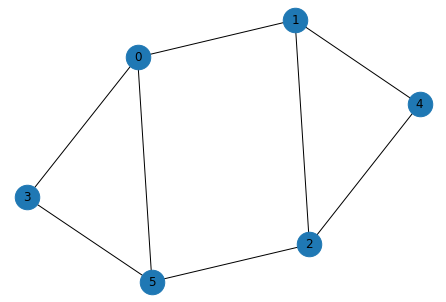

In [2]:
# We generate a random graph with num_nodes nodes and num_edges edges to run Max Cut on.
# num_nodes is the number of qubits, so each circuit will have runtime exponential in num_nodes
num_nodes = 6
num_edges = 8
seed = 1967
    
graph = nx.gnm_random_graph(num_nodes, num_edges, seed=seed)

# Draw the graph
positions = nx.spring_layout(graph, seed=seed)
nx.draw(graph, with_labels=True, pos=positions, node_size=600)

## Prepare input data
We also need to prepare the input data for training. The input data can be specified by either a path to a local file, or an S3 path that points to the data. In this notebook, the input data is the random graph we created. We simply create a file in the local directory encoding the input graph.

In [3]:
input_file_path = "input-data.adjlist"
nx.write_adjlist(graph, input_file_path)

In [4]:
# Job output data will be sent to this bucket by default,
# unless output_data_config is specified in "AwsQuantumJob.create".
aws_session = AwsSession()
bucket = aws_session.default_bucket()
print(bucket)

amazon-braket-your-bucket-name


## Specify hyperparameters and configurations
The hyperparameters can be forwarded to the algorithm script through the keyword argument <code>hyperparameters</code>. It usually includes, but not limited to, the variables that are required to define a training procedure, such as the number of iterations, or to set up an optimizer, such as the learning rate. Here, we pack these hyperparameters into a dictionary which will later become the input of the orchestration script. <code>device_arn</code> has a dedicated input channel so we do not include it in the hyperparameters.

In [5]:
# Pick 'autograd', 'tf', or 'torch'. Autograd is base PennyLane
interface = "autograd"
# Specify device that the job will primarily be targeting
device_arn = "arn:aws:braket:::device/quantum-simulator/amazon/sv1"

hyperparameters = {
    # Number of tasks per iteration = 2 * (num_nodes + num_edges) * p + 1
    "p": "2",
    "seed": str(seed),
    # Maximum number of simultaneous tasks allowed
    "max_parallel": "10",
    # Number of total optimization iterations, including those from previous checkpoint (if any)
    "num_iterations": "5",
    # Step size / learning rate for gradient descent
    "stepsize": "0.1",
    # Shots for each circuit execution
    "shots": "1000",
    "interface": interface,
}

Braket Job has three pre-built containers. The base container does not include PennyLane, so we need to use either the TensorFlow or PyTorch container.

In [6]:
region = aws_session.region

# Choose the container based on which one we need.
if interface == 'autograd':
    # Base container does not have PennyLane, so we have to use the TF or PyTorch container
    image_uri = retrieve_image(Framework.PL_TENSORFLOW, region)
elif interface == 'tf':
    image_uri = retrieve_image(Framework.PL_TENSORFLOW, region)
elif interface == 'torch':
    image_uri = retrieve_image(Framework.PL_PYTORCH, region)

## Algorithm script
The complete algorithm script for solving the Max-Cut problem with QAOA is [here](qaoa_source/qaoa_algorithm_script.py).

## Submitting a Braket Job
We have now finished preparing the input data, algorithm script, hyperparameters and other configurations. It's time to submit out Braket Job!

- <code>device_arn</code>: The arn of the Braket simulator or QPU we want to use. It will be stored as an environment variable for the algorithm script.
- <code>source_module</code>: The path to a file or a python module that contains your algorithm script. It will be uploaded to the container for Braket Job execution.
- <code>job_name</code>: A unique string to identify the job. It appears in the Braket Job console and in the job arn.
- <code>image_uri</code>: The path to a Docker container image.
- <code>entry point</code>: The path relative to the source_module. It points to the piece of code to be executed when the Braket Job starts.
- <code>copy_checkpoints_from_job</code>: A string that specifies the job arn whose checkpoint you want to use in the current job. If `None` (default value), no checkpoints will be copied to the current job.
- <code>hyperparameters</code>: The Python dictionary containing the hyperparameter names and values (as strings).
- <code>input_data</code>: A dictionary that maps channel names to either a file location in the local environment or a path to S3. We can also specify only a file location, in which case the channel name is treated as "input".
- <code>wait_until_complete</code>: If true, the function call will wait until the Braket Job is completedd, and will additionally print logs to the local console. Otherwise, it will run asynchronously.

In [7]:
start_time = time.time()

job = AwsQuantumJob.create(
    device_arn=device_arn,
    source_module="qaoa_source",
    # Any unique name works. Note 50-character limit in job name
    # (comment out to use default naming)
    job_name="JobTest-"+interface+"-"+str(int(time.time())),
    image_uri=image_uri,
    # Relative to the current location
    entry_point="qaoa_source.qaoa_algorithm_script",
    copy_checkpoints_from_job=None,
    # general parameters
    hyperparameters=hyperparameters,
    input_data={"input-graph": input_file_path},
    # Comment out the following line if you want to run the job
    # silently and asynchronously
    wait_until_complete=True,
)

end_time = time.time()

Initializing Braket Job: arn:aws:braket:<region>:<account-id>:job/<job-name>
..............................................
2021-11-05 06:15:49.580043: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2021-11-05 06:15:49.601131: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2021-11-05 06:15:49.719983: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2021-11-05 06:15:53,256 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
2021-11-05 06:15:53,256 sagemaker-training-toolkit INFO     Failed to parse hyperparameter interface value autograd to Json.
Returning the value itself
2021-11-05 06:15:53,262 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-11-05 06:15:53,279 s

  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Created wheel for amazon-braket-schemas: filename=amazon_braket_schemas-1.4.1.dev0-py3-none-any.whl size=70390 sha256=483e332804cc62e1aa8d50b9181fd6133a884d6b8e53f2f395cd38b064c2c536
  Stored in directory: /root/.cache/pip/wheels/57/98/0b/db999598ccda095c5cdec9bef611264ed23d8f0e37f3871d6f
Successfully built amazon-braket-schemas
  Attempting uninstall: amazon-braket-schemas
    Found existing installation: amazon-braket-schemas 1.2.2
    Uninstalling amazon-braket-schemas-1.2.2:
      Successfully uninstalled amazon-braket-schemas-1.2.2
Completed 244.8 KiB/244.8 KiB (267.3 KiB/s) with 1 file(s) remaining#015download: s3://braket-external-assets-preview-us-west-2/HybridJobsAccess/libraries/amazon-braket-sdk-python.tar.

  Created wheel for amazon-braket-sdk: filename=amazon_braket_sdk-1.9.6.dev0-py3-none-any.whl size=152554 sha256=ecc0a9dcb829155d3f7e7381161db5000ec992cd88ecf70d05f0f2a660d1bfdd
  Stored in directory: /root/.cache/pip/wheels/9d/50/f5/3223a6160b514ea71c23d922bbf17833e4a90280c1787b0aaf
Successfully built amazon-braket-sdk
  Attempting uninstall: amazon-braket-sdk
    Found existing installation: amazon-braket-sdk 1.7.1
    Uninstalling amazon-braket-sdk-1.7.1:
      Successfully uninstalled amazon-braket-sdk-1.7.1
Completed 36.1 KiB/36.1 KiB (52.5 KiB/s) with 1 file(s) remaining#015download: s3://braket-external-assets-preview-us-west-2/HybridJobsAccess/models/braket-2019-09-01.normal.json to ../../braket/additional_lib/original/braket-2019-09-01.normal.json
Running Code As Subprocess
environ({'PATH': '/usr/local/openmpi/bin/:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin', 'HOSTNAME': 'ip-10-0-92-211.ec2.internal', 'AMZN_BRAKET_IMAGE_SETUP_SCRIPT': 's3://braket-external-as

Initial cost: -4.031
Metrics - timestamp=1636093004.451293; Cost=-4.031; iteration_number=0;
Completed iteration 1
Time to complete iteration: 25.376688957214355 seconds
Cost at step 1: -3.971
Metrics - timestamp=1636093030.3478534; Cost=-3.971; iteration_number=1;
Completed iteration 2
Time to complete iteration: 25.89508366584778 seconds
Cost at step 2: -4.049
Metrics - timestamp=1636093077.6408274; Cost=-4.049; iteration_number=2;
Completed iteration 3
Time to complete iteration: 47.29233717918396 seconds
Cost at step 3: -4.065
Metrics - timestamp=1636093100.4212093; Cost=-4.065; iteration_number=3;
Completed iteration 4
Time to complete iteration: 22.779675483703613 seconds
Cost at step 4: -4.6
Metrics - timestamp=1636093123.940281; Cost=-4.6; iteration_number=4;
Completed iteration 5
Time to complete iteration: 23.51820135116577 seconds
Metrics - timestamp=1636093126.7218544; Cost=-4.755; iteration_number=5;
Cost at step 5: -4.755
Code Run Finished
  DEPRECATION: A future pip vers

In [8]:
print(end_time - start_time)

456.4561302661896


## View results

After the job is completed, we can view the results and the metric we defined in the algorithm script.

In [9]:
print(job.result())

{'params': [[0.3585011957637408, 0.25568120680522044], [-0.24425138802088256, -0.41761989905871677]], 'cost': -4.755}


In [10]:
# May need to wait a bit before metrics show up
# If metrics aren't there, run a bit later
time.sleep(60)
print(job.metrics())

{'timestamp': [1636093126.7218544, 1636093123.940281, 1636093100.4212093, 1636093077.6408274, 1636093030.3478534, 1636093004.451293], 'Cost': [-4.755, -4.6, -4.065, -4.049, -3.971, -4.031], 'iteration_number': [5.0, 4.0, 3.0, 2.0, 1.0, 0.0]}


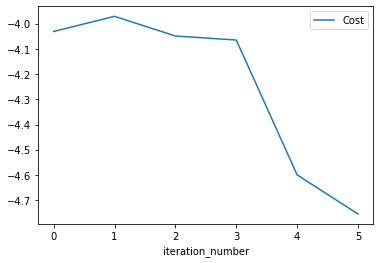

In [11]:
# A demonstration of plotting the metrics

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pandas as pd

df = pd.DataFrame(job.metrics())

ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
figure = df.plot(x='iteration_number', y='Cost', ax=ax)

## Checkpoints

What if a job terminated early for an unforeseen reason, and we would like to continue training? In this case, we can create a new job, and load its training progress from a *checkpoint*. During training, the algorithm script contains this code:

In [12]:
%%script echo "Code in the algorithm script for saving a checkpoint"

for iteration in range(start_iteration, num_iterations):
    # Training code omitted ...
    # ...
    save_job_checkpoint(
        checkpoint_data={
            "iteration": iteration + 1,
            "params": np_params.tolist(),
            "cost_before": cost_before,
        },
        checkpoint_file_suffix="checkpoint-1",
    )

Code in the algorithm script for saving a checkpoint


This code creates and overwrites a checkpoint file `<jobname>-checkpoint-1.json` in your Job artifacts under a subfolder checkpoints. To load the checkpoint, at the start of training the algorithm script contains this code:

In [13]:
%%script echo "Code in the algorithm script for loading a checkpoint"

if "copy_checkpoints_from_job" in hyperparams:
    copy_checkpoints_from_job = hyperparams["copy_checkpoints_from_job"].split("/", 2)[-1]

if copy_checkpoints_from_job:
    checkpoint_1 = load_job_checkpoint(
        copy_checkpoints_from_job,
        checkpoint_file_suffix="checkpoint-1",
    )
    start_iteration = checkpoint_1["iteration"]
    params = interface.initialize_params(np.array(checkpoint_1["params"]))
    print("Checkpoint loaded")

Code in the algorithm script for loading a checkpoint


This starts off the algorithm from the iteration and the parameters specified in the checkpoint file.

Let us see loading a checkpoint in action. We create a new job using the checkpoint from our existing job, this time training for another 2 iterations:

In [14]:
new_hyperparameters = dict(hyperparameters)
# Increase number of iterations by 2
new_hyperparameters["num_iterations"] = str(int(hyperparameters["num_iterations"]) + 2)
# Also add previous job arn in new hyperparameters
new_hyperparameters["copy_checkpoints_from_job"] = job.arn

start_time = time.time()

continued_job = AwsQuantumJob.create(
    device_arn=device_arn,
    source_module="qaoa_source",
    job_name="JobTestContd-"+interface+"-"+str(int(time.time())),
    image_uri=image_uri,
    entry_point="qaoa_source.qaoa_algorithm_script",
    # We specify the previous job arn to copy checkpoints from
    copy_checkpoints_from_job=job.arn,
    hyperparameters=new_hyperparameters,
    input_data={"input-graph": input_file_path},
    wait_until_complete=True,
)

end_time = time.time()

Initializing Braket Job: arn:aws:braket:<region>:<account-id>:job/<job-name>
.................................................
2021-11-05 06:24:45.795494: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2021-11-05 06:24:45.802957: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2021-11-05 06:24:45.979163: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2021-11-05 06:24:50,333 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
2021-11-05 06:24:50,333 sagemaker-training-toolkit INFO     Failed to parse hyperparameter copy_checkpoints_from_job value arn:aws:braket:<region>:<account-id>:job/<job-name> to Json.
Returning the value itself
2021-11-05 06:24:50,334 sagemaker-training-toolkit INFO     Failed to 

Completed 50.5 KiB/50.5 KiB (69.8 KiB/s) with 1 file(s) remaining#015download: s3://braket-external-assets-preview-us-west-2/HybridJobsAccess/libraries/amazon-braket-schemas-python.tar.gz to ../../braket/additional_lib/original/amazon-braket-schemas-python.tar.gz
aws-amazon-braket-schemas-python-staging-6ffc1f24d0886b62d721a8c99fe2366d1f62822e/.coveragerc
aws-amazon-braket-schemas-python-staging-6ffc1f24d0886b62d721a8c99fe2366d1f62822e/.github/
aws-amazon-braket-schemas-python-staging-6ffc1f24d0886b62d721a8c99fe2366d1f62822e/.github/ISSUE_TEMPLATE/
aws-amazon-braket-schemas-python-staging-6ffc1f24d0886b62d721a8c99fe2366d1f62822e/.github/ISSUE_TEMPLATE/bug_report.md
aws-amazon-braket-schemas-python-staging-6ffc1f24d0886b62d721a8c99fe2366d1f62822e/.github/ISSUE_TEMPLATE/config.yml
aws-amazon-braket-schemas-python-staging-6ffc1f24d0886b62d721a8c99fe2366d1f62822e/.github/ISSUE_TEMPLATE/documentation_request.md
aws-amazon-braket-schemas-python-staging-6ffc1f24d0886b62d721a8c99fe2366d1f62822

  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Created wheel for amazon-braket-schemas: filename=amazon_braket_schemas-1.4.1.dev0-py3-none-any.whl size=70390 sha256=3bd1e0a4fba1fb365bc80e1e9a0c6d75bde48481755a84e37687a11133fb61e0
  Stored in directory: /root/.cache/pip/wheels/57/98/0b/db999598ccda095c5cdec9bef611264ed23d8f0e37f3871d6f
Successfully built amazon-braket-schemas
  Attempting uninstall: amazon-braket-schemas
    Found existing installation: amazon-braket-schemas 1.2.2
    Uninstalling amazon-braket-schemas-1.2.2:
      Successfully uninstalled amazon-braket-schemas-1.2.2
Completed 244.8 KiB/244.8 KiB (285.9 KiB/s) with 1 file(s) remaining#015download: s3://braket-external-assets-preview-us-west-2/HybridJobsAccess/libraries/amazon-braket-sdk-python.tar.

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Created wheel for amazon-braket-sdk: filename=amazon_braket_sdk-1.9.6.dev0-py3-none-any.whl size=152554 sha256=442af75580c25430877cd37cb6be00d225a7dbb2d7f2339808fb5db1460c179d
  Stored in directory: /root/.cache/pip/wheels/9d/50/f5/3223a6160b514ea71c23d922bbf17833e4a90280c1787b0aaf
Successfully built amazon-braket-sdk
  Attempting uninstall: amazon-braket-sdk
    Found existing installation: amazon-braket-sdk 1.7.1
    Uninstalling amazon-braket-sdk-1.7.1:
      Successfully uninstalled amazon-braket-sdk-1.7.1
Completed 36.1 KiB/36.1 KiB (53.7 KiB/s) with 1 file(s) remaining#015download: s3://braket-external-assets-preview-us-west-2/HybridJobsAccess/models/braket-2019-09-01.nor

Cost at step 5: -4.697
Metrics - timestamp=1636093541.9000573; Cost=-4.697; iteration_number=5;
Completed iteration 6
Time to complete iteration: 25.685705423355103 seconds
Cost at step 6: -2.95
Metrics - timestamp=1636093566.8675892; Cost=-2.95; iteration_number=6;
Completed iteration 7
Time to complete iteration: 24.963124752044678 seconds
Metrics - timestamp=1636093569.5993972; Cost=-4.766; iteration_number=7;
Cost at step 7: -4.766
Code Run Finished
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
  DEPRECATION: A future pip version will chang

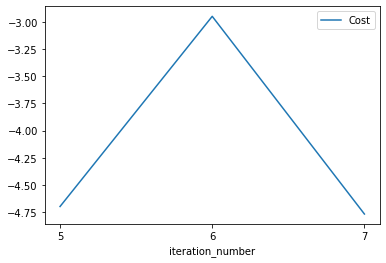

In [15]:
df = pd.DataFrame(continued_job.metrics())

ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
figure = df.plot(x='iteration_number', y='Cost', ax=ax)

## Summary
In this tutorial, we set up a Max-Cut problem with a random graph. We save the graph to a local file and provided it as input data to our Braket Job. Variables that are required to define the training process and the optimizer are passed as hypermeters. The results are retrieved after the QAOA algorithm is completed. Lastly, we demonstrated how to use checkpoints to save and load training progress of a job.